<div style="text-align: center; font-weight: bold; font-size: 200%">Projet - Options basket</div><br />

_A faire pour lundi 16 octobre_

In [22]:
import numpy as np
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from numpy.random import default_rng, SeedSequence

sq = SeedSequence()
rng = default_rng(sq)

# Options basket

On considère $d \ge 2$ actifs financiers dont la loi à l'instant $T > 0$ est modélisée par une loi log-normale c'est à dire 
$$
    \forall i \in \{1,\dots,d\}, \quad
    S^i_T = S^i_0 \exp\Bigl( \bigl(r-\frac{\sigma_i^2}{2}\bigr) T + \sigma_i \sqrt{T} \tilde G_i \Bigr)
$$
où le vecteur $(\tilde G_1,\dots, \tilde G_d)$ est gaussien centré de matrice de covariance $\Sigma$ et les constantes $r > 0$, $\sigma_i > 0$ sont fixées. Il s'agit d'actifs financiers $(S^i_t)_{t \in [0,T]}$, $1 \le i \le d$, modélisés par un processus de Black-Scholes multidimensionnel. On introduit la matrice $L$ triangulaire inférieure obtenue par la décomposition de Cholesky de la matrice $\Sigma = L L^\top$. 

A l'aide de cette matrice $L$, on définit la fonction $\Phi:\mathbf{R}^d \to \mathbf{R}^d$ telle que 
$$
    (S^1_T, \dots, S^d_T) = \Phi(G_1, \dots, G_d) \quad \text{ou encore} \quad S^i_T = \Phi_i(G_1, \dots, G_d)
$$
où $(G_1, \dots, G_d) \sim \mathcal{N}(0, I_d)$ (l'égalité précédente est à considérer en loi).

## Approximation Monte Carlo

On s'intéresse au prix d'une option européenne (aussi appelé produit dérivé européen) sur le panier de ces $d$ actifs financiers, c'est à dire qu'on veut calculer 
$$
    e^{-rT} \mathbf{E} \bigl[ X \bigr] %\quad \text{avec} \quad g(x) = (x-K)_+ \quad \text{ou} \quad g(x) = (K-x)_+ 
    \quad \text{avec} \quad 
    X = \biggl(\frac{1}{d} \sum_{i=1}^d S^i_T  - K\biggr)_+
$$

In [23]:
from Black76 import Black76
from MonteCarlo import MonteCarlo
from utility import get_vanilla_payoff
from typing import Union, Any, Tuple
from numpy.typing import NDArray
from numpy import float_

### Parameters initialization

In [3]:
d = 40
vols = np.ones(d)
S_0 = 100 * np.ones(d)
r = 0.1
T = 1
K = [80, 90, 100, 110, 120]
flag = 'c'
rho = 0.3
corr_mat = np.ones((d, d)) * rho + (1 - rho) * np.eye(d)

F_0 = S_0 * np.exp(r * T)
print('Minimal eigenvalue:', np.min(np.linalg.eigvals(corr_mat)))

model = Black76(
    sigma=vols,
    correlation=corr_mat,
    r=r,
    dim=d
)

Minimal eigenvalue: (0.6999999999999991+0j)


### Model initialization

In [4]:
def MC_basket_price(
        T: Union[float, NDArray[float_]],
        K: Union[float, NDArray[float_]],
        F: Union[float, NDArray[float_]],
        flag: str,
        model: Black76,
        n_sample: int, 
        confidence_level: float = 0.95,
        rng: np.random.Generator = None,
        antithetic_variates: bool = False,
        control_variate: bool = False
) -> Tuple[Union[float, NDArray[float_]], MonteCarlo]:
    """
        Calculates the basket option price in the given model via Monte Carlo simulation.

        Args:
            T: times to maturity.
            K: strikes.
            F: forward prices at t = 0.
            flag: 'c' for calls, 'p' for puts.
            model: Black-76 model.
            n_sample: number of the trajectories.
            confidence_level: Monte Carlo confidence level.
            rng: `np.random.Generator` used for simulation.
            antithetic_variates: whether to use antithetic variantes in simulation. If True, the trajectories
                in the second half of the sample will use the random numbers opposite to the ones used in the first half.

        Returns:
            Monte Carlo price,s and confidence interval,s.
    """
    if rng is None:
        rng = np.random.default_rng(seed=42)
    S_T_sample = model.simulate_trajectory(
        size=n_sample,
        t_grid=np.array([T]),
        init_val=F,
        rng=rng,
        antithetic_variates=antithetic_variates
    ).squeeze() # array of shape (n_sample, dim)
    basket_sample = S_T_sample.mean(axis=1)
    payoff = get_vanilla_payoff(np.array(K)[None, :], flag)
    sample = payoff(np.exp(-r * T) * basket_sample[:, None])
    if control_variate:
        covariance = model.sigma[:, None] * model.sigma[None, :] * model.correlation
        sigma_IV = np.sqrt(covariance.mean())
        Z = np.mean(np.log(S_T_sample / F_0), axis=1) + 0.5 * np.mean(model.sigma**2) * T - 0.5 * sigma_IV**2 * T
        cv = np.exp(-model.r * T) * payoff(np.mean(F) * np.exp(Z[:, None]))
        cv_mean = Black76(sigma=sigma_IV, r=model.r).vanilla_price(T, np.array(K)[None, :], np.mean(F), flag)
        sample -= cv - cv_mean
    if antithetic_variates:
        sample = 0.5 * (sample[:n_sample // 2] + sample[n_sample // 2:])
    return S_T_sample, MonteCarlo(sample, confidence_level=confidence_level)

In [10]:
n_sample = 10**6
rng = np.random.default_rng(seed=0xAB0BA)
S_T, mc = MC_basket_price(T, K, F_0, flag, model, n_sample, rng=rng)

In [11]:
for strike, price, CI_dev in zip(K, mc.mean, mc.accuracy):
    print(f'Monte Carlo price of the option with strike {strike}:', np.round(price, 4), "±", np.round(CI_dev, 4))

Monte Carlo price of the option with strike 80: 31.6177 ± 0.1042
Monte Carlo price of the option with strike 90: 26.6194 ± 0.0988
Monte Carlo price of the option with strike 100: 22.3953 ± 0.0931
Monte Carlo price of the option with strike 110: 18.8436 ± 0.0875
Monte Carlo price of the option with strike 120: 15.8626 ± 0.082


Implémenter un estimateur Monte Carlo pour calculer au centime près le prix pour différentes valeurs de $K$, $K \in \{80, 90, 100, 110, 120\}$.

## Réduction de variance

Implémenter les méthodes de réduction de variance suivantes, et comparer les temps de calcul et la complexité: 
1. Méthode des variables antithétiques en considérant $(W^1_T, \dots, W^d_T)$ et $(-W^1_T, \dots, -W^d_T)$,
2. Utilisation de la variable de contrôle $Y = \bigl(\bar S_0 e^Z  - K\bigr)_+$ avec $\bar S_0 = \frac{1}{d} \sum_{i=1}^d S^i_0$ et $Z = \sum_{i=1}^d a^i_0 \big(\mu_i T + \sigma_i \sqrt{T} \tilde G_i\big)$,
3. Un mélange des 2 méthodes précédentes.

### Variables antithétiques

In [12]:
n_sample = 10**6
rng = np.random.default_rng(seed=0xAB0BA)
S_T_antith, mc_antith = MC_basket_price(T, K, F_0, flag, model, n_sample, rng=rng, antithetic_variates=True)

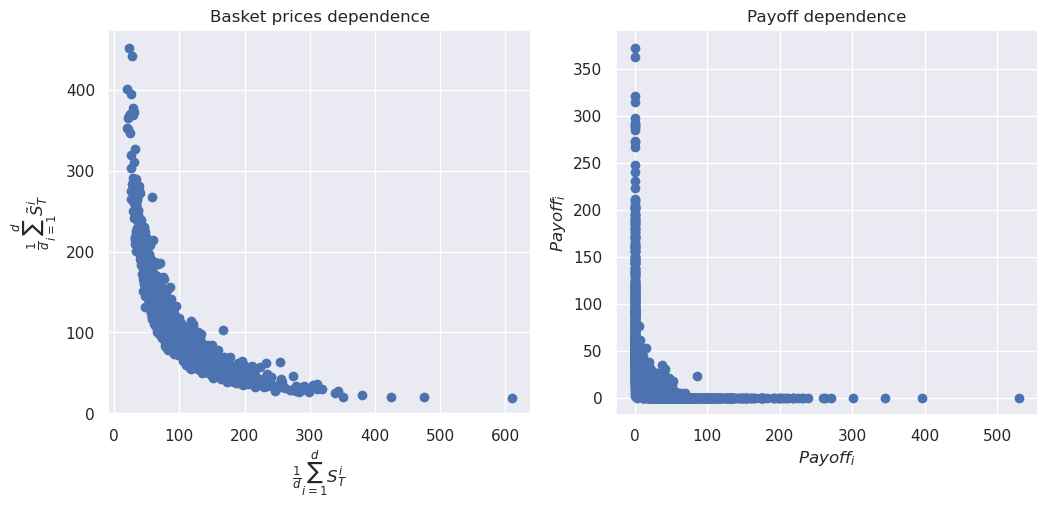

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(S_T_antith[:1000].mean(axis=1), S_T_antith[n_sample // 2:n_sample // 2 + 1000].mean(axis=1))
ax[0].set_title('Basket prices dependence')
ax[0].set_xlabel(r'$\frac{1}{d}\sum_{i=1}^d S_T^i$')
ax[0].set_ylabel(r'$\frac{1}{d}\sum_{i=1}^d\tilde S_T^i$')
payoff = get_vanilla_payoff(K[0], flag)
ax[1].scatter(payoff(S_T_antith[:1000].mean(axis=1)), payoff(S_T_antith[n_sample // 2:n_sample // 2 + 1000].mean(axis=1)))
ax[1].set_title('Payoff dependence')
ax[1].set_xlabel(r'$Payoff_i$')
ax[1].set_ylabel(r'$Payoff_{\tilde i}$')
plt.show()

In [14]:
for strike, price, CI_dev in zip(K, mc_antith.mean, mc_antith.accuracy):
    print(f'Monte Carlo price of the option with strike {strike}:', np.round(price, 4), "±", np.round(CI_dev, 4))

Monte Carlo price of the option with strike 80: 31.6164 ± 0.0839
Monte Carlo price of the option with strike 90: 26.6125 ± 0.0837
Monte Carlo price of the option with strike 100: 22.384 ± 0.082
Monte Carlo price of the option with strike 110: 18.8312 ± 0.0791
Monte Carlo price of the option with strike 120: 15.8518 ± 0.0757


### Variable de contrôle $Y = \bigl(\bar S_0 e^Z  - K\bigr)_+$ avec $\bar S_0 = \frac{1}{d} \sum_{i=1}^d S^i_0$ et $Z = \sum_{i=1}^d a^i_0 \big(\mu_i T + \sigma_i \sqrt{T} \tilde G_i\big)$

On choisit $a_0$ et $\mu$ tels que
$$
\mathbb{E}\left[\bar S_0 e^Z\right] = \mathbb{E}\left[ \dfrac1d\sum_{i=1}^dS_T^i \right].
$$
On pose $a_0^i = \dfrac1d$ et on calcule
$$
\mathbb{E}\left[ \dfrac1d\sum_{i=1}^dS_T^i \right] = \bar S_0 e^{rT}.
$$
et
$$
\mathbb{E}\left[\bar S_0 e^Z\right] = \bar S_0 \exp\left\{(r + \bar\mu)T + \dfrac{T}2\sum_{i,j}\rho_{ij}\sigma_i\sigma_j\right\}, 
$$
où $\bar\mu = \dfrac1d\sum_{i=1}^d \mu_i$. $\mu_i$ peuvent être donc choisit $\mu_i = -\dfrac12\sum_{j=1}\rho_{ij}\sigma_i\sigma_j$.
On note que dans ce cas $Z$ s'écrit
$$
Z = \dfrac1d\sum_{i=1}^d\ln\dfrac{S_T^i}{S_0^i} + \dfrac1d\sum_{i=1}^d\sigma_i^2T - \dfrac{1}{d^2}\sum_{i=1}^d\sum_{j=1}^d\rho_{ij}\sigma_i\sigma_jT
$$
De plus, 
$$
Z = \left(r - \dfrac{1}{2d^2}\sum_{i=1}^d\sum_{j=1}^d\rho_{ij}\sigma_i\sigma_j\right)T + \dfrac{1}{2d}\sum_{i=1}^d\sigma_i\sqrt{T}\tilde G_i
$$
et donc
$$
\mathbb{E}\left(\bar S_0 e^Z - K\right)_+ = \mathrm{BS}\left(S_0 = \bar S_0,\ \sigma = \dfrac1d\sqrt{\sum_{i=1}^d\sum_{j=1}^d\rho_{ij}\sigma_i\sigma_j}\right)
$$

In [16]:
n_sample = 10**6
rng = np.random.default_rng(seed=0xAB0BA)
S_T_control, mc_control = MC_basket_price(T, K, F_0, flag, model, n_sample, rng=rng, control_variate=True)

In [17]:
for strike, price, CI_dev in zip(K, mc_control.mean, mc_control.accuracy):
    print(f'Monte Carlo price of the option with strike {strike}:', np.round(price, 4), "±", np.round(CI_dev, 4))

Monte Carlo price of the option with strike 80: 31.6465 ± 0.0201
Monte Carlo price of the option with strike 90: 26.6448 ± 0.02
Monte Carlo price of the option with strike 100: 22.4165 ± 0.0198
Monte Carlo price of the option with strike 110: 18.8608 ± 0.0196
Monte Carlo price of the option with strike 120: 15.8768 ± 0.0192


### Mélange des 2 méthodes

In [19]:
n_sample = 10**6
rng = np.random.default_rng(seed=0xAB0BA)
S_T_both, mc_both = MC_basket_price(T, K, F_0, flag, model, n_sample, rng=rng, antithetic_variates=True, control_variate=True)

In [20]:
for strike, price, CI_dev in zip(K, mc.mean, mc.accuracy):
    print(f'Monte Carlo price of the option with strike {strike}:', np.round(price, 4), "±", np.round(CI_dev, 4))

Monte Carlo price of the option with strike 80: 31.6177 ± 0.1042
Monte Carlo price of the option with strike 90: 26.6194 ± 0.0988
Monte Carlo price of the option with strike 100: 22.3953 ± 0.0931
Monte Carlo price of the option with strike 110: 18.8436 ± 0.0875
Monte Carlo price of the option with strike 120: 15.8626 ± 0.082


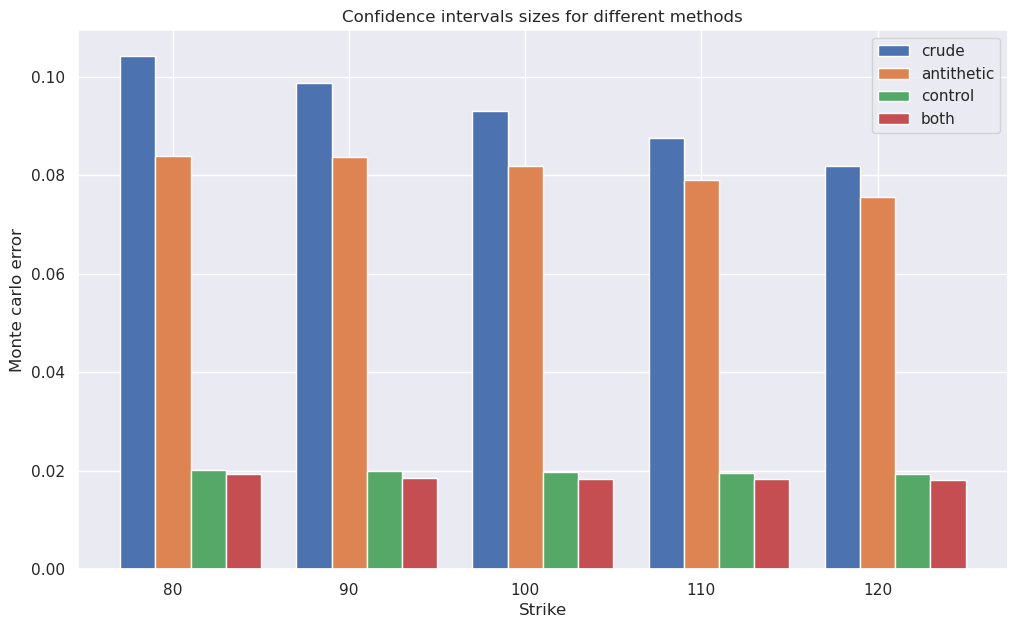

In [21]:
fig, ax = plt.subplots(figsize=(12, 7))

devs = {
    'crude': mc.accuracy,
    'antithetic': mc_antith.accuracy,
    'control': mc_control.accuracy,
    'both': mc_both.accuracy
}

x = np.arange(len(K))  
width = 0.2 
multiplier = 0

for method, dev in devs.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, dev, width, label=method)
    multiplier += 1

ax.set_xlabel('Strike')
ax.set_ylabel('Monte carlo error')
ax.set_title('Confidence intervals sizes for different methods')
ax.set_xticks(x + width)
ax.set_xticklabels(map(str, K))
ax.legend(loc='upper right')

plt.show()